In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pylab as pl
from datetime import datetime, timedelta
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
! curl -L https://github.com/fedhere/PUI2017_fb55/blob/master/HW10_fb55/MTA_Fare.npy?raw=true > $PUIDATA/MTA_Fare.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   139    0   139    0     0    139      0 --:--:-- --:--:-- --:--:--  1061
100   150  100   150    0     0    150      0  0:00:01 --:--:--  0:00:01   150
100 10.2M  100 10.2M    0     0  10.2M      0  0:00:01 --:--:--  0:00:01 10.2M


In [3]:
data = np.load(os.environ["PUIDATA"] + '/MTA_Fare.npy')

In [4]:
# 1. Event detection: Identify the most prominent event. 
# There is a very significant drop (>3-sigma) in all time series.
# Sum over the stations to only look at individual cards.

stations_flat = numpy.sum(data, axis=0)
print(stations_flat.shape)
stations_flat2 = numpy.sum(stations_flat, axis=0)
print(stations_flat2.shape)

thresholds = [stations_flat2.mean() + 3 * stations_flat2.std(), 
              stations_flat2.mean() - 3 * stations_flat2.std()]

(23, 194)
(194,)


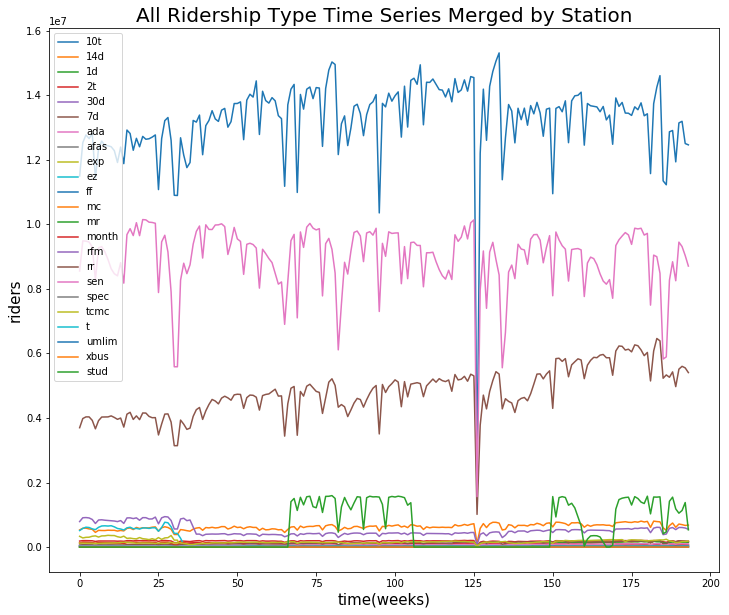

In [5]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
pl.figure(figsize =(12,10))
for i in range(len(stations_flat)):
    pl.plot(range(len(stations_flat[i])), stations_flat[i], label = ridetype[i])
pl.ylabel('riders', fontsize =15)
pl.xlabel('time(weeks)', fontsize =15)
pl.title('All Ridership Type Time Series Merged by Station', fontsize =20)
pl.legend()

Figure #1:

Plotted are a the 23 different card type time series of ridership

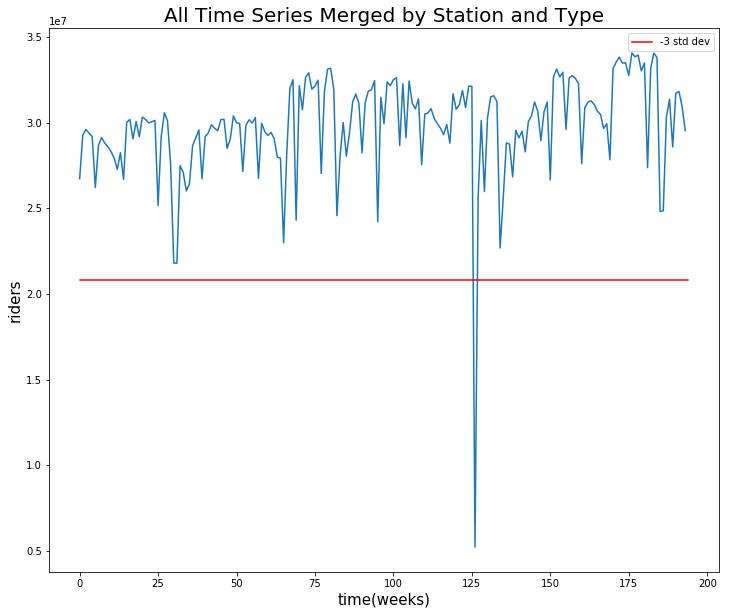

In [6]:
# plotting double flattened series
pl.figure(figsize =(12,10))
pl.plot(range(len(stations_flat2)), stations_flat2)
pl.xlabel('week')
pl.plot((0, len(stations_flat2)), (thresholds[1],thresholds[1]), 'r-', label = '-3 std dev')
pl.ylabel('riders', fontsize =15)
pl.xlabel('time(weeks)', fontsize =15)
pl.title('All Time Series Merged by Station and Type', fontsize =20)
pl.legend()

Figure #2:

Plotted is the summed time series of all stations and card types.  The one dip of the series below the red line representing a -3 standard deviation from the mean is from Hurrican Sandy.

In [7]:
# What week was that?
np.array(range(len(stations_flat2)))[(stations_flat2 < thresholds[1])]

array([126])

In [8]:
d1 = datetime.date(2010, 5, 2)
d2 = datetime.date(2014, 2, 21)
monday1 = (d1 - timedelta(days=d1.weekday()))
monday2 = (d2 - timedelta(days=d2.weekday()))

print ('Weeks:', (monday2 - monday1).days / 7)

Weeks: 199.0


There are 5 weeks missing.

In [9]:
# Find difference in weeks for when Sandy occured
d1 = datetime.date(2010, 5, 21)
d2 = datetime.date(2012, 10, 22)
monday1 = (d1 - timedelta(days=d1.weekday()))
monday2 = (d2 - timedelta(days=d2.weekday()))

print ('Weeks:', (monday2 - monday1).days / 7)

Weeks: 127.0


126 weeks after 05/21/2010 is 2 years, 22 weeks and just before when hurricane Sandy occured.  This makes sense as a time when subway ridership would drop way off and then it explains why we have a missing week of data for when tunnels and trains got flooded.

In [10]:
#2. Find Ridership types that have increased and decreased
# remove negative values from data since they wil throw off ratios
no_neg = data
no_neg[no_neg<0] = 10
stations_flat = numpy.sum(no_neg, axis=0)
print(stations_flat.shape)


(23, 194)


In [11]:
# Transform each series with rolling mean
rm_by_card = np.zeros((23, 194))
for i in range(len(stations_flat)):
    rm_by_card[i] = pd.rolling_mean(stations_flat[i], 10, min_periods=1)

rm_by_card 

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


array([[  1.14959950e+07,   1.20121220e+07,   1.22640803e+07, ...,
          1.29198827e+07,   1.27963471e+07,   1.26178502e+07],
       [  5.31904000e+05,   5.58413500e+05,   5.68130333e+05, ...,
          6.93654200e+05,   6.80289900e+05,   6.69199700e+05],
       [  4.91810000e+04,   5.10285000e+04,   5.16876667e+04, ...,
          5.86202000e+04,   5.77534000e+04,   5.68329000e+04],
       ..., 
       [  7.50800000e+03,   7.50900000e+03,   7.62600000e+03, ...,
          6.71580000e+03,   6.70150000e+03,   6.73910000e+03],
       [  1.73800000e+03,   1.80100000e+03,   1.81233333e+03, ...,
          2.22570000e+03,   2.19710000e+03,   2.16960000e+03],
       [  6.00000000e+03,   6.00000000e+03,   6.00000000e+03, ...,
          1.18825730e+06,   1.17111980e+06,   1.06991760e+06]])

In [12]:
# Now I can take the ratio of rm_by_card[i][9] and rm_by_card[i][193] 
# to find ratio of first and last 10 weeks
ten_week_diff = np.zeros(23)
for i in range(len(rm_by_card)):
    ten_week_diff[i] = rm_by_card[i][9]  / rm_by_card[i][193]
# make df to see indexes
dif_df = pd.DataFrame({'index': list(range(23)), 'first_divided_last' : ten_week_diff})
dif_df = dif_df.sort_values('first_divided_last')
dif_df

,first_divided_last,index
22,0.005608,22
12,0.009494,12
17,0.054932,17
16,0.353460,16
15,0.390643,15
18,0.655160,18
5,0.719625,5
1,0.799086,1
11,0.825500,11
21,0.851862,21


The ride type  ez (index 9) has decreased the most and the ride type student (index 22)  as increase the most, plotting

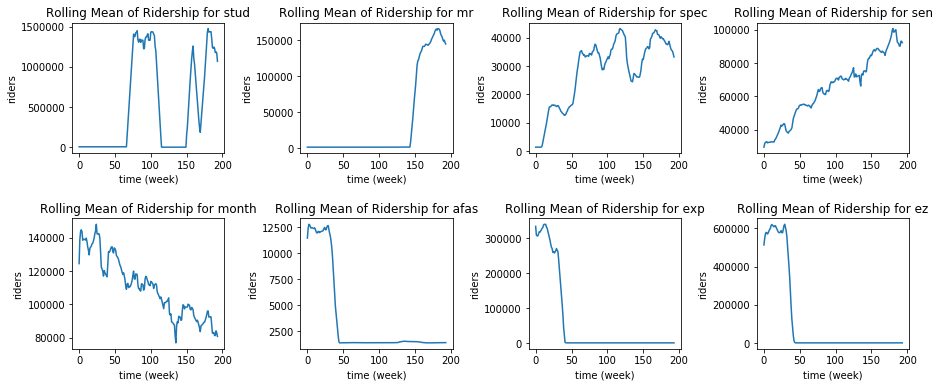

In [13]:
# Now we want to plot the top 4 bottom and top to be sure that 
# their rolling mean differences are from constant trends no just jumps
idx_to_plot = [22, 12, 17, 16, 13, 7, 8, 9]


fig, axs = pl.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)

axs = axs.ravel()

for i in range(8):
    to_plot = idx_to_plot[i]
    axs[i].plot(range(len(rm_by_card[to_plot])), rm_by_card[to_plot])
    axs[i].set_title('Rolling Mean of Ridership for ' + ridetype[to_plot])
    axs[i].set_xlabel('time (week)')
    axs[i].set_ylabel('riders')

Fig #3:

Plotted are the smoothed ridership values from 8 time series that increased or decresed the most from the first 10 weeks to the last 10 weeks. Looking at these plots, it is clear that some of the top changes are due to card types being phased in or out and not a growth in their use.  For card that trended up over time the 'sen' card for seniors I assume has an acutal trend up over time.  For a downward trend the 'month' card has a continuous decrease.

In [14]:
#3 . Find 4 stations with most prominent periodic trend on an annual period (52 weeks)
cardtype_flat = numpy.sum(data, axis=1)
print(cardtype_flat.shape)

(600, 194)


In [15]:
# Now take the fourier transform for each series
fts = np.zeros((600, 98))
for i in range(len(cardtype_flat)):
    fts[i] = (np.fft.rfft(cardtype_flat[i]).real)**2

Text(0.5,1,'Periodicity of Ridership')

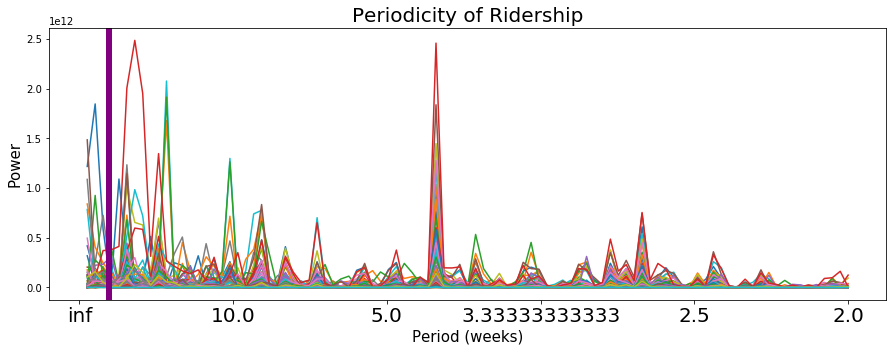

In [16]:
# plot a few to check it out
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(len(fts))[0:100]:
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (fts[i][1:]))
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
ax.axvline(x=(1/52), ymin = 0, ymax=1e13, linewidth=6, color='purple')
pl.ylabel('Power', fontsize=15)
pl.xlabel('Period (weeks)', fontsize=15)
pl.title('Periodicity of Ridership', fontsize=20)

Fig #4:

The power of periodicity is plotted for 100 stations.  A line is drawn at the x value of the plot representing a yearly period.

In [17]:
# Which index of values corresponds to 1/52?
(1 / np.fft.rfftfreq(194, 1.0))[:6]

array([          inf,  194.        ,   97.        ,   64.66666667,
         48.5       ,   38.8       ])

Index 4 is closes to yearly

In [18]:
# Now loop through all 600 stations
# Find max value at index 4
yearly_power = np.zeros(600)
max_power_val = 0
max_power_id = 999
for i in range(len(fts)):
    yearly_power[i]= fts[i][4]
    if yearly_power[i] > max_power_val:
        max_power_id = i
        max_power_val = yearly_power[i]

print('The station with the highest power is ' + str(max_power_id))
    

The station with the highest power is 32


In [19]:
power_df = pd.DataFrame({'index' : list(range(600)), 'power': yearly_power})
power_df.sort_values('power', ascending=False).head()

,index,power
32,32,4.133533e+11
83,83,3.773789e+11
169,169,3.487052e+11
54,54,3.116275e+11
327,327,2.218741e+11


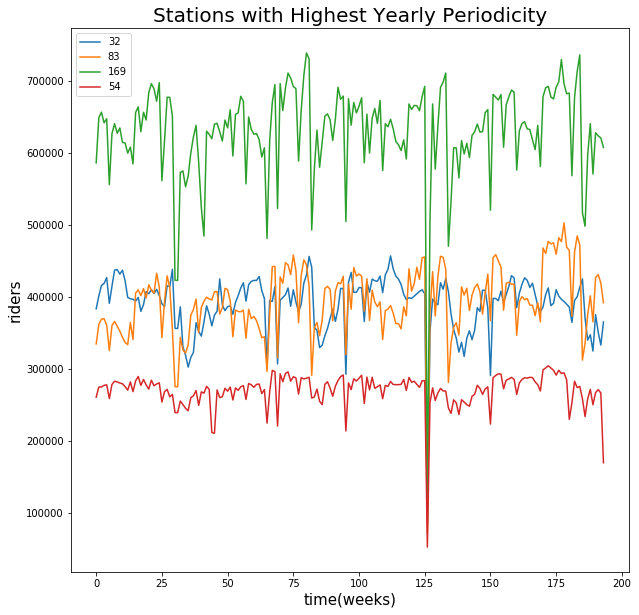

In [20]:
to_plot = [32, 83, 169, 54]
pl.figure(figsize =(10,10))
for i in to_plot:
    pl.plot(range(len(cardtype_flat[i])), cardtype_flat[i], label=str(i))
pl.ylabel('riders', fontsize=15)
pl.xlabel('time(weeks)', fontsize=15)
pl.title('Stations with Highest Yearly Periodicity', fontsize=20)
pl.legend()


Figure #5:

Plotted are the time series for the 4 stations with the highest power values close to 52 weeks.  These are the stations with ridership that cycles yearly the most.  I would expect some of these stations to be near beaches or other places that would be much more popular in the summer than other months.

Grade: 10/10